Architecture
At a high-level, the steps of any SQL chain and agent are:

Convert question to SQL query: Model converts user input to a SQL query.
Execute SQL query: Execute the SQL query.
Answer the question: Model responds to user input using the query results.
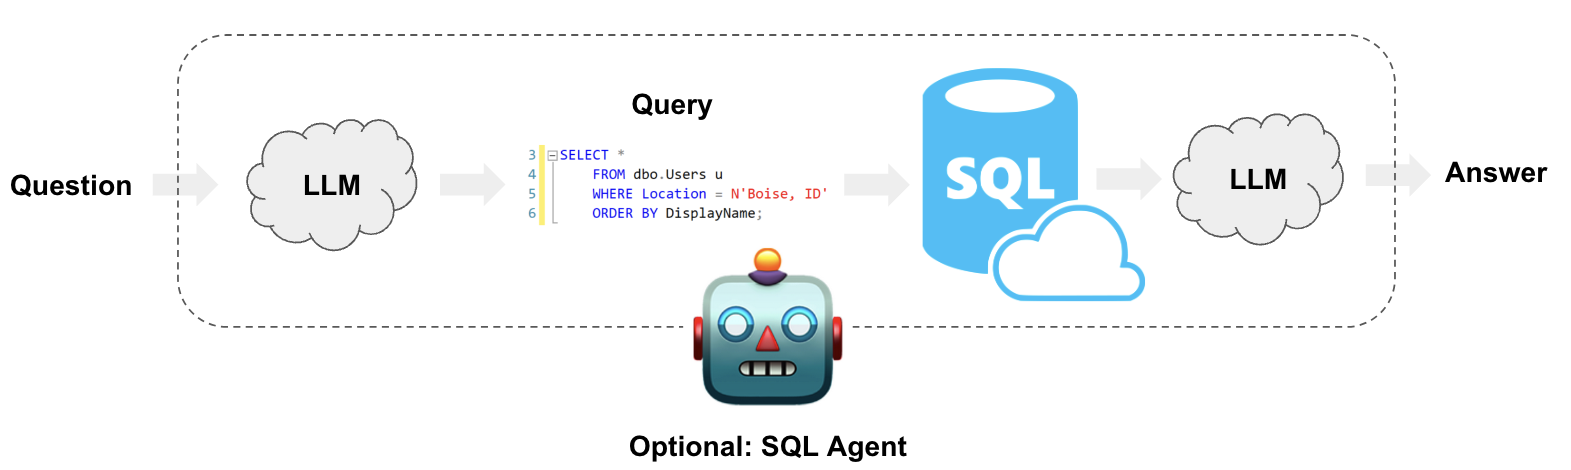

# Create a test schema

In [1]:
import sqlite3


db_path = '/content/sample.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

script='''
CREATE TABLE Cart (
    Cart_id TEXT PRIMARY KEY NOT NULL
);

CREATE TABLE Customer (
    Customer_id TEXT PRIMARY KEY NOT NULL,
    c_pass TEXT NOT NULL,
    Name TEXT NOT NULL,
    Address TEXT NOT NULL,
    Pincode INTEGER NOT NULL,
    Phone_number_s INTEGER NOT NULL,
    Cart_id TEXT NOT NULL,
    FOREIGN KEY(Cart_id) REFERENCES Cart(Cart_id)
);

CREATE TABLE Seller (
    Seller_id TEXT PRIMARY KEY NOT NULL,
    s_pass TEXT NOT NULL,
    Name TEXT NOT NULL,
    Address TEXT NOT NULL
);

CREATE TABLE Seller_Phone_num (
    Phone_num INTEGER NOT NULL,
    Seller_id TEXT NOT NULL,
    PRIMARY KEY (Phone_num, Seller_id),
    FOREIGN KEY (Seller_id) REFERENCES Seller(Seller_id) ON DELETE CASCADE
);

CREATE TABLE Payment (
    payment_id TEXT PRIMARY KEY NOT NULL,
    payment_date DATE NOT NULL,
    Payment_type TEXT NOT NULL,
    Customer_id TEXT NOT NULL,
    Cart_id TEXT NOT NULL,
    total_amount REAL,
    FOREIGN KEY (Customer_id) REFERENCES Customer(Customer_id),
    FOREIGN KEY (Cart_id) REFERENCES Cart(Cart_id)
);

CREATE TABLE Product (
    Product_id TEXT PRIMARY KEY NOT NULL,
    Type TEXT NOT NULL,
    Color TEXT NOT NULL,
    P_Size TEXT NOT NULL,
    Gender TEXT NOT NULL,
    Commission INTEGER NOT NULL,
    Cost INTEGER NOT NULL,
    Quantity INTEGER NOT NULL,
    Seller_id TEXT,
    FOREIGN KEY (Seller_id) REFERENCES Seller(Seller_id) ON DELETE SET NULL
);

CREATE TABLE Cart_item (
    Quantity_wished INTEGER NOT NULL,
    Date_Added DATE NOT NULL,
    Cart_id TEXT NOT NULL,
    Product_id TEXT NOT NULL,
    purchased TEXT DEFAULT 'NO',
    PRIMARY KEY (Cart_id, Product_id),
    FOREIGN KEY (Cart_id) REFERENCES Cart(Cart_id),
    FOREIGN KEY (Product_id) REFERENCES Product(Product_id)
);

'''

cursor.executescript(script)
conn.commit()
conn.close()


In [2]:
db_path = '/content/sample.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

sql_script = '''
-- Insert data into Cart table
INSERT INTO Cart VALUES ('crt1011');
INSERT INTO Cart VALUES ('crt1012');
INSERT INTO Cart VALUES ('crt1013');
INSERT INTO Cart VALUES ('crt1014');
INSERT INTO Cart VALUES ('crt1015');

-- Insert data into Customer table
INSERT INTO Customer VALUES ('cid100', 'ABCM1235', 'rajat', 'G-453', 632014, 9893135876, 'crt1011');
INSERT INTO Customer VALUES ('cid101', 'XYZ5678', 'john', 'F-789', 560023, 9876543210, 'crt1012');
INSERT INTO Customer VALUES ('cid102', 'PQRS9876', 'jane', 'A-321', 400001, 8765432109, 'crt1013');
INSERT INTO Customer VALUES ('cid103', 'LMNO4567', 'smith', 'H-567', 110011, 7654321098, 'crt1014');
INSERT INTO Customer VALUES ('cid104', 'EFGH3456', 'alice', 'D-876', 700012, 6543210987, 'crt1015');

-- Insert data into Seller table
INSERT INTO Seller VALUES ('sid100', '12345', 'aman', 'delhi cmc');
INSERT INTO Seller VALUES ('sid101', '67890', 'sara', 'mumbai abc');
INSERT INTO Seller VALUES ('sid102', '45678', 'peter', 'kolkata xyz');
INSERT INTO Seller VALUES ('sid103', '98765', 'lisa', 'bangalore pqr');
INSERT INTO Seller VALUES ('sid104', '23456', 'mike', 'chennai lmn');

-- Insert data into Product table
INSERT INTO Product VALUES ('pid1001', 'jeans', 'red', '32', 'M', 10, 10005, 20, 'sid100');
INSERT INTO Product VALUES ('pid1002', 'shirt', 'blue', 'L', 'F', 5, 5000, 15, 'sid101');
INSERT INTO Product VALUES ('pid1003', 'shoes', 'black', '40', 'M', 8, 8000, 25, 'sid102');
INSERT INTO Product VALUES ('pid1004', 'dress', 'green', 'S', 'F', 12, 12000, 18, 'sid103');
INSERT INTO Product VALUES ('pid1005', 'hat', 'white', 'Free', 'U', 3, 300, 30, 'sid104');

-- Insert data into Seller_Phone_num table
INSERT INTO Seller_Phone_num VALUES (9943336206, 'sid100');
INSERT INTO Seller_Phone_num VALUES (9876543210, 'sid101');
INSERT INTO Seller_Phone_num VALUES (8765432109, 'sid102');
INSERT INTO Seller_Phone_num VALUES (7654321098, 'sid103');
INSERT INTO Seller_Phone_num VALUES (6543210987, 'sid104');

-- Insert data into Cart_item table
INSERT INTO Cart_item VALUES (3, '1999-10-10', 'crt1011', 'pid1001', 'Y');
INSERT INTO Cart_item VALUES (2, '2000-05-15', 'crt1012', 'pid1002', 'N');
INSERT INTO Cart_item VALUES (4, '2001-08-20', 'crt1013', 'pid1003', 'Y');
INSERT INTO Cart_item VALUES (1, '2002-12-25', 'crt1014', 'pid1004', 'N');
INSERT INTO Cart_item VALUES (5, '2003-04-30', 'crt1015', 'pid1005', 'Y');

-- Insert data into Payment table
INSERT INTO Payment VALUES ('pmt1001', '1999-10-10', 'online', 'cid100', 'crt1011', 6000);
INSERT INTO Payment VALUES ('pmt1002', '2000-05-15', 'cash', 'cid101', 'crt1012', 2500);
INSERT INTO Payment VALUES ('pmt1003', '2001-08-20', 'card', 'cid102', 'crt1013', 5000);
INSERT INTO Payment VALUES ('pmt1004', '2002-12-25', 'paypal', 'cid103', 'crt1014', 3000);
INSERT INTO Payment VALUES ('pmt1005', '2003-04-30', 'online', 'cid104', 'crt1015', 10000);

'''


cursor.executescript(sql_script)

conn.commit()
conn.close()


# Install Dependencies and connect to database

In [15]:
!pip install -q langchain openai langchain-openai langchain-experimental faiss-cpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 71.3 MB/s eta 0:00:00


In [4]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain_openai import OpenAI
from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI


In [5]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [6]:
db = SQLDatabase.from_uri("sqlite:////content/sample.db")

In [7]:
gpt = ChatOpenAI(openai_api_key=OPENAI_API_KEY,model="gpt-3.5-turbo", temperature=0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


# Setup Agent and Ask a query

In [8]:
toolkit = SQLDatabaseToolkit(db=db, llm=gpt)

In [9]:
agent_executor = create_sql_agent(
    llm=gpt,
    toolkit=toolkit,
    verbose=True,
    agent_type="openai-tools",
)

In [10]:
question = "what is the cart amount for customer with customer id cid101"
agent_executor.run(question)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


Cart, Cart_item, Customer, Payment, Product, Seller, Seller_Phone_num
Invoking: `sql_db_schema` with `Cart, Customer`



CREATE TABLE "Cart" (
	"Cart_id" TEXT NOT NULL, 
	PRIMARY KEY ("Cart_id")
)

/*
3 rows from Cart table:
Cart_id
crt1011
crt1012
crt1013
*/


CREATE TABLE "Customer" (
	"Customer_id" TEXT NOT NULL, 
	c_pass TEXT NOT NULL, 
	"Name" TEXT NOT NULL, 
	"Address" TEXT NOT NULL, 
	"Pincode" INTEGER NOT NULL, 
	"Phone_number_s" INTEGER NOT NULL, 
	"Cart_id" TEXT NOT NULL, 
	PRIMARY KEY ("Customer_id"), 
	FOREIGN KEY("Cart_id") REFERENCES "Cart" ("Cart_id")
)

/*
3 rows from Customer table:
Customer_id	c_pass	Name	Address	Pincode	Phone_number_s	Cart_id
cid100	ABCM1235	rajat	G-453	632014	9893135876	crt1011
cid101	XYZ5678	john	F-789	560023	9876543210	crt1012
cid102	PQRS9876	jane	A-321	400001	8765432109	crt1013
*/
Invoking: `sql_db_query` with `SELECT c.Cart_id, c.Customer_id, c.Name, c.Address, c

"The cart amount for the customer with customer id 'cid101' is 5000."

In [55]:
question = "what is the name and phone number of the seller sid102"
agent_executor.run(question)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


Cart, Cart_item, Customer, Payment, Product, Seller, Seller_Phone_num
Invoking: `sql_db_schema` with `Seller`



CREATE TABLE "Seller" (
	"Seller_id" TEXT NOT NULL, 
	s_pass TEXT NOT NULL, 
	"Name" TEXT NOT NULL, 
	"Address" TEXT NOT NULL, 
	PRIMARY KEY ("Seller_id")
)

/*
3 rows from Seller table:
Seller_id	s_pass	Name	Address
sid100	12345	aman	delhi cmc
sid101	67890	sara	mumbai abc
sid102	45678	peter	kolkata xyz
*/
Invoking: `sql_db_query` with `SELECT Name, Seller_Phone_num FROM Seller WHERE Seller_id = 'sid102'`


Error: (sqlite3.OperationalError) no such column: Seller_Phone_num
[SQL: SELECT Name, Seller_Phone_num FROM Seller WHERE Seller_id = 'sid102']
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_schema` with `Seller_Phone_num`



CREATE TABLE "Seller_Phone_num" (
	"Phone_num" INTEGER NOT NULL, 
	"Seller_id" TEXT NOT NULL, 
	PRIMARY KEY ("Phone_num", "Seller_id"),

'The name of the seller with ID sid102 is Peter and their phone number is 8765432109.'

In [56]:
question = "Find total profit of the website from sales."
agent_executor.run(question)



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


Cart, Cart_item, Customer, Payment, Product, Seller, Seller_Phone_num
Invoking: `sql_db_schema` with `Payment`



CREATE TABLE "Payment" (
	payment_id TEXT NOT NULL, 
	payment_date DATE NOT NULL, 
	"Payment_type" TEXT NOT NULL, 
	"Customer_id" TEXT NOT NULL, 
	"Cart_id" TEXT NOT NULL, 
	total_amount REAL, 
	PRIMARY KEY (payment_id), 
	FOREIGN KEY("Customer_id") REFERENCES "Customer" ("Customer_id"), 
	FOREIGN KEY("Cart_id") REFERENCES "Cart" ("Cart_id")
)

/*
3 rows from Payment table:
payment_id	payment_date	Payment_type	Customer_id	Cart_id	total_amount
pmt1001	1999-10-10	online	cid100	crt1011	6000.0
pmt1002	2000-05-15	cash	cid101	crt1012	2500.0
pmt1003	2001-08-20	card	cid102	crt1013	5000.0
*/
Invoking: `sql_db_query` with `SELECT SUM(total_amount) AS total_profit FROM Payment`


[(26500.0,)]The total profit of the website from sales is $26,500.

> Finished chain.


'The total profit of the website from sales is $26,500.'

# Using a dynamic few-shot prompt

To optimize agent performance, we can provide a custom prompt with domain-specific knowledge. In this case we'll create a few shot prompt with an example selector, that will dynamically build the few shot prompt based on the user input.

First we need some user input <> SQL query examples:

In [11]:
examples = [
    {"input": "List all customers.", "query": "SELECT * FROM Customer;"},
    {
        "input": "List all the products from a particular seller with seller_id 'sid100'",
        "query": "SELECT Product.Product_id, Product.Type, Product.Color, Product.P_Size, Product.Gender, Product.Commission, Product.Cost, Product.Quantity FROM Product WHERE Product.Seller_id = 'sid100';",
    },
    {
        "input": "List of all sellers  with name address and their phone number",
        "query": "SELECT Seller.Seller_id, Seller.Name AS Seller_Name, Seller_Phone_num.Phone_num AS Seller_Phone_Number FROM Seller JOIN Seller_Phone_num ON Seller.Seller_id = Seller_Phone_num.Seller_id;",
    },
    {
        "input": "List of all the items in the cart of a customer whose Name is 'jane'",
        "query": "SELECT Cart_item.Quantity_wished,  Cart_item.Date_Added, Cart_item.Cart_id, Cart_item.Product_id, Cart_item.purchased FROM Cart_item JOIN Cart ON Cart_item.Cart_id = Cart.Cart_id JOIN Customer ON Cart.Customer_id = Customer.Customer_id WHERE Customer.Name = 'Jane';;",
    },
    {
        "input": "List all customers whose address is Canada.",
        "query": "SELECT * FROM Customer WHERE Country = 'Canada';",
    },
    {
        "input": "How many customers have purchased the product with Product_id pid1002",
        "query": "SELECT COUNT(DISTINCT Customer_id) AS Num_Customers_Purchased FROM Cart_item WHERE Product_id = 'pid1002' AND purchased = 'Y'; ",
    },
    {
        "input": "Find the total number of Products.",
        "query": "SELECT COUNT(*) FROM Product;",
    },
    {
        "input": "How many customers are there",
        "query": 'SELECT COUNT(*) AS Total_Customers FROM "Customer"',
    },
]

In [16]:
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_openai import OpenAIEmbeddings

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples,
    OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY),
    FAISS,
    k=5,
    input_keys=["input"],
)

In [17]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    FewShotPromptTemplate,
    MessagesPlaceholder,
    PromptTemplate,
    SystemMessagePromptTemplate,
)

system_prefix = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't know" as the answer.

Here are some examples of user inputs and their corresponding SQL queries:"""

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=PromptTemplate.from_template(
        "User input: {input}\nSQL query: {query}"
    ),
    input_variables=["input", "dialect", "top_k"],
    prefix=system_prefix,
    suffix="",
)

In [18]:
full_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate(prompt=few_shot_prompt),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

In [19]:
# Example formatted prompt
prompt_val = full_prompt.invoke(
    {
        "input": "List of all sellers  with name address and their phone number",
        "top_k": 5,
        "dialect": "SQLite",
        "agent_scratchpad": [],
    }
)
print(prompt_val.to_string())

System: You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't 

In [21]:
agent = create_sql_agent(
    llm=gpt,
    db=db,
    prompt=full_prompt,
    verbose=True,
    agent_type="openai-tools",
)

In [22]:
agent.invoke({"input": "List of all sellers  with name address and their phone number"})



> Entering new AgentExecutor chain...

Invoking: `sql_db_query` with `SELECT Seller.Name, Seller.Address, Seller_Phone_num.Phone_num FROM Seller JOIN Seller_Phone_num ON Seller.Seller_id = Seller_Phone_num.Seller_id`


[('aman', 'delhi cmc', 9943336206), ('sara', 'mumbai abc', 9876543210), ('peter', 'kolkata xyz', 8765432109), ('lisa', 'bangalore pqr', 7654321098), ('mike', 'chennai lmn', 6543210987)]Here is a list of all sellers with their name, address, and phone number:

1. Seller Name: aman
   Address: delhi cmc
   Phone Number: 9943336206

2. Seller Name: sara
   Address: mumbai abc
   Phone Number: 9876543210

3. Seller Name: peter
   Address: kolkata xyz
   Phone Number: 8765432109

4. Seller Name: lisa
   Address: bangalore pqr
   Phone Number: 7654321098

5. Seller Name: mike
   Address: chennai lmn
   Phone Number: 6543210987

> Finished chain.


{'input': 'List of all sellers  with name address and their phone number',
 'output': 'Here is a list of all sellers with their name, address, and phone number:\n\n1. Seller Name: aman\n   Address: delhi cmc\n   Phone Number: 9943336206\n\n2. Seller Name: sara\n   Address: mumbai abc\n   Phone Number: 9876543210\n\n3. Seller Name: peter\n   Address: kolkata xyz\n   Phone Number: 8765432109\n\n4. Seller Name: lisa\n   Address: bangalore pqr\n   Phone Number: 7654321098\n\n5. Seller Name: mike\n   Address: chennai lmn\n   Phone Number: 6543210987'}

In [23]:
agent.invoke({"input": "List of all customers  with their phone number"})



> Entering new AgentExecutor chain...

Invoking: `sql_db_query` with `SELECT Customer.Customer_id, Customer.Name AS Customer_Name, Customer_Phone_num.Phone_num AS Customer_Phone_Number FROM Customer JOIN Customer_Phone_num ON Customer.Customer_id = Customer_Phone_num.Customer_id`


Error: (sqlite3.OperationalError) no such table: Customer_Phone_num
[SQL: SELECT Customer.Customer_id, Customer.Name AS Customer_Name, Customer_Phone_num.Phone_num AS Customer_Phone_Number FROM Customer JOIN Customer_Phone_num ON Customer.Customer_id = Customer_Phone_num.Customer_id]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Invoking: `sql_db_schema` with `Customer`



CREATE TABLE "Customer" (
	"Customer_id" TEXT NOT NULL, 
	c_pass TEXT NOT NULL, 
	"Name" TEXT NOT NULL, 
	"Address" TEXT NOT NULL, 
	"Pincode" INTEGER NOT NULL, 
	"Phone_number_s" INTEGER NOT NULL, 
	"Cart_id" TEXT NOT NULL, 
	PRIMARY KEY ("Customer_id"), 
	FOREIGN KEY("Cart_id") REFERENCES "Cart" ("Cart_id")
)

/*
3 rows 

{'input': 'List of all customers  with their phone number',
 'output': 'Here is a list of all customers with their phone numbers:\n\n1. Customer ID: cid100, Name: rajat, Phone Number: 9893135876\n2. Customer ID: cid101, Name: john, Phone Number: 9876543210\n3. Customer ID: cid102, Name: jane, Phone Number: 8765432109\n4. Customer ID: cid103, Name: smith, Phone Number: 7654321098\n5. Customer ID: cid104, Name: alice, Phone Number: 6543210987'}